In [91]:
import numpy as np
import pandas as pd

from tqdm import tqdm
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [37]:
aq_data = xr.open_dataset("../processed_data/delhi_cpcb_2022_cleaned.nc")
aq_data.station.values

array(['Alipur, Delhi - DPCC', 'Anand Vihar, Delhi - DPCC',
       'Ashok Vihar, Delhi - DPCC', 'Aya Nagar, Delhi - IMD',
       'Bawana, Delhi - DPCC', 'Burari Crossing, Delhi - IMD',
       'CRRI Mathura Road, Delhi - IMD', 'Chandni Chowk, Delhi - IITM',
       'DTU, Delhi - CPCB',
       'Dr. Karni Singh Shooting Range, Delhi - DPCC',
       'Dwarka-Sector 8, Delhi - DPCC ', 'IGI Airport (T3), Delhi - IMD',
       'IHBAS, Dilshad Garden, Delhi - CPCB', 'ITO, Delhi - CPCB',
       'Jahangirpuri, Delhi - DPCC',
       'Jawaharlal Nehru Stadium, Delhi - DPCC',
       'Lodhi Road, Delhi - IITM', 'Lodhi Road, Delhi - IMD',
       'Major Dhyan Chand National Stadium, Delhi - DPCC',
       'Mandir Marg, Delhi - DPCC', 'Mundka, Delhi - DPCC',
       'NSIT Dwarka, Delhi - CPCB', 'Najafgarh, Delhi - DPCC',
       'Narela, Delhi - DPCC', 'Nehru Nagar, Delhi - DPCC',
       'North Campus, DU, Delhi - IMD', 'Okhla Phase-2, Delhi - DPCC',
       'Patparganj, Delhi - DPCC', 'Punjabi Bagh, Delhi - 

In [38]:
def insert_rmse(df):
    df["RMSE"] = np.sqrt((df["PM2.5"] - df["PM2.5_pred"]) ** 2)

models = {"IDW-P1": "results/loocv_idw_p=1", "IDW-P2": "results/loocv_idw_p=2", "IDW-P3": "results/loocv_idw_p=3", "RF": "results/loocv_rf", "LR": "results/loocv_lr", "mean": "results/loocv_mean", "kriging": "results/loocv_kriging"}

rmse_df = pd.DataFrame(index=aq_data.station.values, columns=models.keys()).astype(float)
overall_rmse = pd.Series(index=models.keys())

base_df = pd.read_csv("results/loocv_idw_p=1")
for model in tqdm(models):
    df = pd.read_csv(f"{models[model]}")
    df["time"] = pd.to_datetime(base_df["time"])
    df["station"] = base_df["station"]
    df = df.set_index("time", drop=False)
    insert_rmse(df)
    for station in aq_data.station.values:
        rmse_df.loc[station, model] = df[df.station == station]["RMSE"].mean()
    overall_rmse[model] = df["RMSE"].mean()

/tmp/ipykernel_3281964/1130702705.py:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  overall_rmse = pd.Series(index=models.keys())
100%|██████████| 7/7 [00:10<00:00,  1.44s/it]


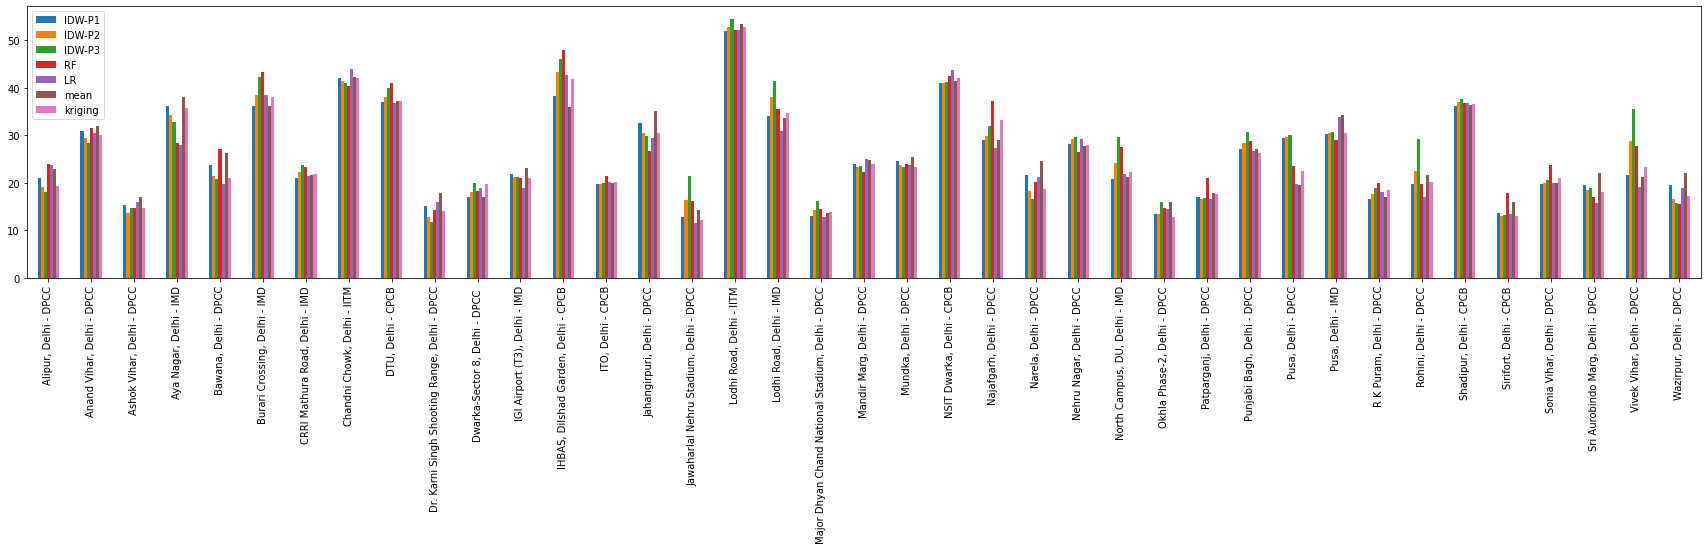

In [39]:
# create compound bar chart for RMSE where x-axis is station and y-axis is RMSE
fig, ax = plt.subplots(figsize=(30, 5))
rmse_df.plot.bar(ax=ax)

# rotate x-axis labels
plt.xticks(rotation=90);

In [40]:
overall_rmse.sort_values()

LR         24.156350
kriging    24.576691
IDW-P1     24.686193
IDW-P2     25.044864
mean       25.489823
RF         25.783608
IDW-P3     26.202653
dtype: float64

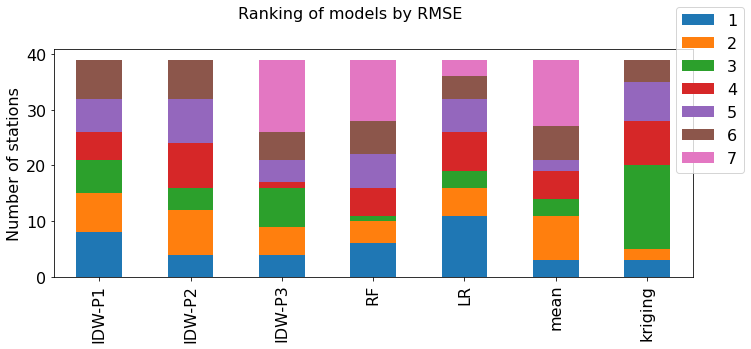

In [95]:
# create another df called argsort_df where each row is ranked by RMSE
rank_df = rmse_df.rank(axis=1).astype(int)

value_counts_df = pd.DataFrame(index=rank_df.columns, columns=range(1, len(rank_df.columns)+1))
for model in rank_df.columns:
    value_counts_df.loc[model] = rank_df[model].value_counts().sort_index()
    
value_counts_df.fillna(0, inplace=True)
value_counts_df = value_counts_df.astype(int)

plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(10, 5))
value_counts_df.plot.bar(figsize=(10, 5), stacked=True, ax=ax, legend=False)
ax.set_ylabel("Number of stations")
fig.legend(loc="upper center", bbox_to_anchor=(1, 1));
fig.suptitle("Ranking of models by RMSE", fontsize=16)
fig.tight_layout()